In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import robit
import ik

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import odrive
from odrive.utils import *
import math
from trot_controller import TrotController

In [ ]:
robit.detect(3)

In [166]:
R = robit.Robit(enable_diagnostic=True)

In [167]:
R.add_controller(('205B39964D4D', 'Front_Left_Lower', 'Front_Left_Hip')) # left

looking for device 205B39964D4D
found device


In [168]:
R.add_controller(('206E39A24D4D', 'Front_Right_Upper', 'Front_Left_Upper')) # middle

looking for device 206E39A24D4D
found device


In [169]:
R.add_controller(('207D396D4D4D', 'Front_Right_Lower', 'Front_Right_Hip')) # right

looking for device 207D396D4D4D
found device


In [170]:
R.autoconfig ()
#R.reboot ()

In [172]:
R.dump_faults (clear=True)

205B39964D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
206E39A24D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
207D396D4D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


In [35]:
motors = ['Front_Left_Hip', 'Front_Right_Hip']

In [77]:
motors = ['Front_Left_Upper']#, 'Front_Right_Upper']

In [169]:
R.set_states (motors, ['CONTROL'] * len(motors))

In [170]:
R.set_states (motors, ['IDLE'] * len(motors))

In [160]:
r = 0
FLH = list()
FRH = list()
for _ in range(100):
    resistances = R.measure_resistances(motors)
    FLH.append (resistances['Front_Left_Hip'])
    FRH.append (resistances['Front_Right_Hip'])
    time.sleep(0.25)

In [133]:
import time
r = 0
a = list()
b = list()
for _ in range(1000):
    a.append(R.get_motor('Front_Right_Lower').encoder.shadow_count)
    b.append(R.get_motor('Front_Left_Lower').encoder.shadow_count)
    time.sleep(.005)


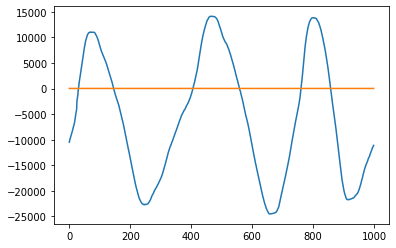

In [134]:
plt.plot (a)
plt.plot (b)

In [76]:
R.set_state ('Front_Left_Upper', 'CALIBRATE')

In [14]:
R.set_state ('Front_Left_Lower', 'CONTROL')

In [39]:
motors = ['Front_Left_Lower', 'Front_Left_Upper', 'Front_Left_Hip', 'Front_Right_Lower', 'Front_Right_Upper', 'Front_Right_Hip']
R.set_states (motors, ['CONTROL'] * len(motors))

In [81]:
motors = ['Front_Left_Lower', 'Front_Left_Upper', 'Front_Left_Hip', 'Front_Right_Lower', 'Front_Right_Upper', 'Front_Right_Hip']
R.set_states (motors, ['IDLE'] * len(motors))

In [35]:
motors = ['Front_Left_Lower', 'Front_Left_Upper', 'Front_Left_Hip', 'Front_Right_Lower', 'Front_Right_Upper', 'Front_Right_Hip']
R.set_states (motors, ['CALIBRATE'] * len(motors))

In [247]:
R.get_motor('Front_Right_Lower').motor.config.direction = 0

In [252]:
R.get_motor('Front_Right_Lower').motor.config.direction

1

In [124]:
motor = 'Front_Right_Lower'
R.dump_faults (clear=True)
R.reset ([motor], [0])
R.set_state (motor, 'CALIBRATE')

205B39964D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
206E39A24D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
207D396D4D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


In [151]:
R.dump_faults (clear=True)

205B39964D4D
axis0
  axis: Error(s):
    ERROR_CONTROLLER_FAILED
  motor: Error(s):
    ERROR_CONTROL_DEADLINE_MISSED
  encoder: no error
  controller: Error(s):
    ERROR_OVERSPEED
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
206E39A24D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
207D396D4D4D
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


In [74]:
motors = ['Front_Right_Hip', 'Front_Right_Upper', 'Front_Right_Lower', 'Front_Left_Hip', 'Front_Left_Upper', 'Front_Left_Lower']
iterations = 1000

forward = np.array ([50, 100, -180])
backward = np.array ([50, -100, -180])

In [179]:
class LegController:
    def __init__(self, mode):
        self.forward_position = np.array ([0, 100, -225])
        self.backward_position = np.array ([0, -10, -225])
        
        self.height = 40
        
        self.timestep = 0
        self.cycle_length = 100
        self.mode = mode # 'forward' or 'backward'
    
    def get_position(self):
        t = self.timestep / self.cycle_length
        if self.mode == 'backward':
            position = t * self.backward_position + (1 - t) * self.forward_position
        elif self.mode == 'forward':
            position = t * self.forward_position + (1 - t) * self.backward_position + np.array([0, 0, np.sin(t * 3.14159) * self.height])
            
        self.timestep += 1
        if self.timestep > self.cycle_length:
            self.timestep = 0
            self.mode = 'forward' if self.mode == 'backward' else 'backward' # toggle mode
        return position
    
class TrotController:
    def __init__(self):
        self.L = LegController('forward')
        self.R = LegController('backward')
        
    def step(self):
        return self.L.get_position(), self.R.get_position()
        

In [181]:
TC = TrotController()

R.set_states (motors, ['CONTROL'] * len(motors))
for i in range (0, 1000):
    pos = TC.step()
    R.place ({'Front_Left': pos[0], 'Front_Right': pos[1]})
    time.sleep (0.01)

In [182]:
R.set_states (motors, ['IDLE'] * len(motors))

In [173]:
R.set_states (motors, ['CALIBRATE'] * len(motors))

In [174]:
R.reset(motors, [0] * len(motors))

In [183]:
R.set_states (motors, ['CONTROL'] * len(motors))

In [184]:
R.set_states (motors, ['IDLE'] * len(motors))

In [121]:
R.set_states (motors, ['IDLE'] * len(motors))

In [228]:
position1 = np.array([50, 0, -240])
position2 = np.array([50, 50, -160])

In [229]:
iterations = 80

In [258]:
R.place({'Front_Left': position1, 'Front_Right': position1})
time.sleep (1)

for i in range (0, iterations):
    p = (1 - i/iterations) * position1 + (i/iterations) * position2
    R.place({'Front_Left': p, 'Front_Right': p})
    time.sleep (0.01)

In [120]:
R.place({'Front_Left': position2, 'Front_Right': position2})
time.sleep (1)

for i in range (0, iterations):
    p = (i/iterations) * position1 + (1 - i/iterations) * position2
    R.place({'Front_Left': p, 'Front_Right': p})
    time.sleep (0.01)
    print (ik.solve(p, 'Front_Right'))


NameError: name 'position2' is not defined

In [ ]:
#TODO: FIX IK :D
#TODO: log encoder positions (using R.get_motor('Front_Left_Lower').encoder.shadow_count) during pushup sequence

In [394]:
position = [50, 0, -190]

a = list()

R.place({'Front_Left': position, 'Front_Right': position})
time.sleep (2)

for _ in range (0, 500):
    position[2] -= .1
    a.append(ik.solve (position, 'Front_Left'))

In [374]:
a = list()

In [92]:
def test_sin (labels, revolutions, amplitude, set_states=False):
    if set_states:
        R.set_states (labels, ['CONTROL'] * len(labels))
    iterations = 1000
    for i in range (iterations):
        R.snap (labels, [math.sin(revolutions * 6.282 * i / iterations) * amplitude] * len(labels))
        time.sleep (5.0 / iterations)
    if set_states:
        R.set_states (labels, ['IDLE'] * len(labels))

In [105]:
test_sin (['Front_Right_Lower'], 2, 1, set_states=True)

In [103]:
R.get_motor('Front_Left_Lower').trap_traj.config

vel_limit = 100000.0 (float)
accel_limit = 500000.0 (float)
decel_limit = 500000.0 (float)
A_per_css = 0.0 (float)

In [413]:
R.autoconfig ()